## Use feature-weighted rf model on the crcns vim-1 dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from time import time
from glob import glob
from scipy.io import loadmat
from PIL import Image
from scipy.stats import pearsonr
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu, bigmult
from hrf_fitting.src.feature_weighted_rf_models import train_fwrf_model
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X


In [2]:
version_number = '1p1'

### Step 0: Load crcns stimuli

#### load crcns stimuli 

In [3]:
##known stimulus parameters
Ttrn = 1750
Tval = 120
S = 500
T = Ttrn+Tval
train_stim_files = glob('/media/tnaselar/Data/crcns_datasets/vim-1/Stimuli_Trn_FullRes*.mat')
val_stim_file = '/media/tnaselar/Data/crcns_datasets/vim-1/Stimuli_Val_FullRes.mat'
n_image_channels = 1 ##could be 3 for color images.

In [4]:
##allocate memory for stim
training_stim = np.zeros((Ttrn,S,S),dtype='float32')

##load training stim
cnt = 0
for sl in sorted(train_stim_files):
    this_h5 = h5py.File(sl,'r')
    this_train_stim = this_h5['stimTrn']
    this_num_stim = this_train_stim.shape[-1]
    training_stim[cnt:cnt+this_num_stim,:,:] = np.transpose(this_train_stim[:],[2,1,0])
    cnt += this_num_stim
    this_h5.close()
    
##load validation stim
val_h5 = h5py.File(val_stim_file,'r')
validation_stim = np.transpose(val_h5['stimVal'][:],[2,1,0])
val_h5.close()

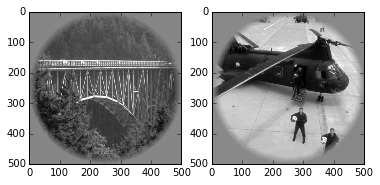

In [5]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(validation_stim[0,:,:],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(training_stim[-1,:,:],cmap = 'gray')

### Step 1: construct feature maps

In [6]:
n_orientations = 8
deg_per_stimulus = 20
lowest_sp_freq = .25 ##cyc/deg
highest_sp_freq = 6.25
num_sp_freq = 8
pix_per_cycle = 4#2.13333333
complex_cell = True

print 'D = total number of features = %d' %(n_orientations * num_sp_freq)

D = total number of features = 64


#### construct gabor wavelet stack

In [7]:
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle,complex_cell=complex_cell,
                         diams_per_filter = 4,
                        cycles_per_radius = 2.0)

In [8]:
gfm.gbr_table.head(9)

,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.250000,16,64.000000,20.000000,64,8.000000,0.000000
1,0.395955,16,40.408642,31.676392,64,5.051080,0.000000
2,0.627121,16,25.513412,50.169691,64,3.189177,0.000000
3,0.993247,16,16.108787,79.459740,64,2.013598,0.000000
4,1.573124,16,10.170847,125.849895,64,1.271356,0.000000
5,2.491544,16,6.421720,199.323532,64,0.802715,0.000000
6,3.946156,16,4.054578,315.692518,64,0.506822,0.000000
7,6.250000,16,2.560000,500.000000,64,0.320000,0.000000
8,0.250000,16,64.000000,20.000000,64,8.000000,0.392699


In [9]:
gfm.filter_stack.shape

(64, 1, 64, 64)

#### see one of the gabors

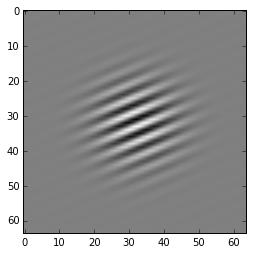

In [10]:
o =  8##choose an orientation
plt.imshow(np.imag(gfm.filter_stack[o,0,:,:]),cmap='gray')

### Step 2: receptive fields

In [11]:
deg_per_radius = (.5, 8, 8) ##rf sizes in degrees (smallest, largest, number of sizes)
spacing = 1. ##spacing between rf's in degrees
rf = receptive_fields(deg_per_stimulus,deg_per_radius,spacing)

In [12]:
rf.rf_table.head()

,deg_per_radius,x_deg,y_deg
0,0.5,-10.000000,-10
1,0.5,-8.947368,-10
2,0.5,-7.894737,-10
3,0.5,-6.842105,-10
4,0.5,-5.789474,-10


In [13]:
print 'G = number of rf models = %d' %(rf.rf_table.shape[0])

G = number of rf models = 3200


### Step 3: Model space

#### apply an activation function

In [14]:
log_act_func = lambda x: np.log(1+np.sqrt(x))

#### instantiate model space object

In [15]:
##construct the model space
init_feat_dict = gfm.create_feature_maps(training_stim[0,np.newaxis,np.newaxis,:,:])
ms = model_space(init_feat_dict, rf, activation_function = log_act_func)

allocating memory for feature maps
constructing feature maps
feature 0 took 0.002987 s.
feature 1 took 0.002397 s.
feature 2 took 0.003229 s.
feature 3 took 0.005392 s.
feature 4 took 0.009205 s.
feature 5 took 0.020953 s.
feature 6 took 0.056721 s.
feature 7 took 0.326315 s.
feature 8 took 0.002223 s.
feature 9 took 0.002335 s.
feature 10 took 0.003083 s.
feature 11 took 0.005301 s.
feature 12 took 0.012244 s.
feature 13 took 0.020212 s.
feature 14 took 0.054678 s.
feature 15 took 0.292964 s.
feature 16 took 0.002082 s.
feature 17 took 0.002342 s.
feature 18 took 0.003111 s.
feature 19 took 0.005231 s.
feature 20 took 0.009463 s.
feature 21 took 0.022265 s.
feature 22 took 0.053830 s.
feature 23 took 0.291967 s.
feature 24 took 0.002074 s.
feature 25 took 0.002378 s.
feature 26 took 0.003206 s.
feature 27 took 0.005653 s.
feature 28 took 0.012133 s.
feature 29 took 0.019666 s.
feature 30 took 0.053654 s.
feature 31 took 0.304833 s.
feature 32 took 0.002055 s.
feature 33 took 0.002375 

#### construct training/validation model space tensors

In [16]:
##loop over training stimuli because feature maps for all training stim. > 48Gb
training_mst = np.zeros((ms.receptive_fields.G, Ttrn, ms.D)).astype('float32')

num_chunks = 2
stim_dx = np.linspace(0,T-1,num=num_chunks+1, endpoint=True,dtype='int')

cnt = 0
for t in stim_dx[1:]:
    this_training_feature_dict = gfm.create_feature_maps(training_stim[cnt:cnt+t,np.newaxis,:,:])
    training_mst[:,cnt:cnt+t,:] = ms.construct_model_space_tensor(this_training_feature_dict,normalize=False)
    cnt += t

##clear up memory
this_training_feature_dict = []

##normalize and save normalization constants
training_mst = ms.normalize_model_space_tensor(training_mst, save=True)


##should work in one shot for because not too big
val_feature_dict = gfm.create_feature_maps(validation_stim[:,np.newaxis,:,:])

allocating memory for feature maps
constructing feature maps
feature 0 took 0.518009 s.
feature 1 took 0.936353 s.
feature 2 took 2.005326 s.
feature 3 took 3.813605 s.
feature 4 took 7.083313 s.
feature 5 took 16.075289 s.
feature 6 took 47.045267 s.
feature 7 took 319.762392 s.
feature 8 took 0.525182 s.
feature 9 took 0.935084 s.
feature 10 took 2.009029 s.
feature 11 took 3.635238 s.
feature 12 took 6.943372 s.
feature 13 took 16.156943 s.
feature 14 took 47.027083 s.
feature 15 took 357.883121 s.
feature 16 took 0.523240 s.
feature 17 took 0.934515 s.
feature 18 took 2.005113 s.
feature 19 took 3.632721 s.
feature 20 took 6.944409 s.
feature 21 took 16.167996 s.
feature 22 took 47.291588 s.
feature 23 took 363.542996 s.
feature 24 took 0.524041 s.
feature 25 took 0.934344 s.
feature 26 took 2.006907 s.
feature 27 took 3.631803 s.
feature 28 took 6.944221 s.
feature 29 took 16.211402 s.
feature 30 took 47.359837 s.
feature 31 took 363.825042 s.
feature 32 took 0.521151 s.
feature 3

In [17]:
validation_mst = ms.construct_model_space_tensor(val_feature_dict,normalize=True)

-----------feature: 0
at pixel resolution 20 the following rfs will default to 0: (array([ 0.5]),)
-----------feature: 1
at pixel resolution 32 the following rfs will default to 0: (array([ 0.5]),)
-----------feature: 2
-----------feature: 3
-----------feature: 4
-----------feature: 5
-----------feature: 6
-----------feature: 7
-----------feature: 8
at pixel resolution 20 the following rfs will default to 0: (array([ 0.5]),)
-----------feature: 9
at pixel resolution 32 the following rfs will default to 0: (array([ 0.5]),)
-----------feature: 10
-----------feature: 11
-----------feature: 12
-----------feature: 13
-----------feature: 14
-----------feature: 15
-----------feature: 16
at pixel resolution 20 the following rfs will default to 0: (array([ 0.5]),)
-----------feature: 17
at pixel resolution 32 the following rfs will default to 0: (array([ 0.5]),)
-----------feature: 18
-----------feature: 19
-----------feature: 20
-----------feature: 21
-----------feature: 22
-----------feature:

### Step 4: load and package crcns voxel data

In [18]:
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file,'r')
crcns_voxel_data.keys()

[u'dataTrnS1',
 u'dataTrnS2',
 u'dataValS1',
 u'dataValS2',
 u'roiS1',
 u'roiS2',
 u'voxIdxS1',
 u'voxIdxS2']

#### remove nans, becuase this data-set has some. otherwise even one nan will infect gradient for every voxel.

In [19]:
voxel_data = np.concatenate((crcns_voxel_data['dataValS1'],crcns_voxel_data['dataTrnS1']),axis=0).astype('float32')

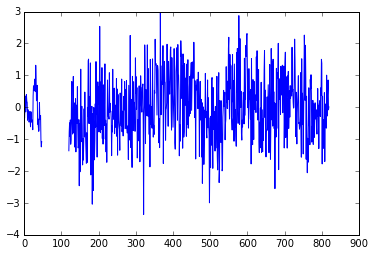

In [20]:
plt.plot(voxel_data[:,-1])

In [21]:
no_nan = np.isnan(voxel_data).sum(axis=0) == 0 ##<<pull voxels with nans 
voxel_data = voxel_data[:,no_nan]
print voxel_data.shape
V = voxel_data.shape[1]

(1870, 22701)


In [22]:
crcns_voxel_data.close()

#### get training/validation views on voxel_data

In [23]:
nvox=V
trnIdx = np.arange(Tval,T)
valIdx = np.arange(0,Tval)
trn_voxel_data = voxel_data[trnIdx,0:nvox]
val_voxel_data = voxel_data[valIdx,0:nvox]

### Step 5: run that shit.

#### train the model!

In [24]:
fvl,ffw,frf,beh = train_fwrf_model(training_mst,
                 trn_voxel_data,
                 initial_feature_weights='zeros',
                 voxel_binsize = nvox,
                 rf_grid_binsize=10,
                 learning_rate=10**(-5.3),
                 max_iters = 200,
                 early_stop_fraction=0.2,
                 report_every = 25)

--------------voxels from 0 to 22701
--------candiate rf models 0 to 10
-------
errors: 345.612425
change in best rf: 105609.000000
norm of feature weights: 1.737473
improvements: 227010
0.426249980927
-------
errors: 344.497953
change in best rf: -18.000000
norm of feature weights: 18.902250
improvements: 59564
9.31998109818
-------
errors: 344.297120
change in best rf: -35.000000
norm of feature weights: 31.610332
improvements: 41760
9.1801431179
-------
errors: 344.248993
change in best rf: -15.000000
norm of feature weights: 42.534813
improvements: 31086
9.07815909386
-------
errors: 344.276866
change in best rf: -17.000000
norm of feature weights: 52.240288
improvements: 23857
9.00408601761
-------
errors: 344.350313
change in best rf: -31.000000
norm of feature weights: 60.972515
improvements: 18793
8.94995093346
-------
errors: 344.453534
change in best rf: -7.000000
norm of feature weights: 68.887718
improvements: 14999
8.90138888359
-------
errors: 344.575057
change in best rf

#### loss histories, all voxels

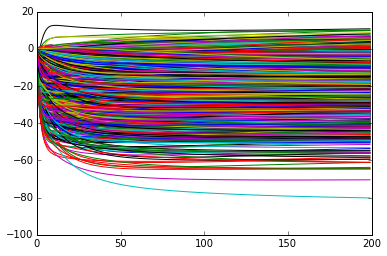

In [25]:
_=plt.plot(beh[:,1:]-beh[0,1:])


#### view loss history for a few voxels

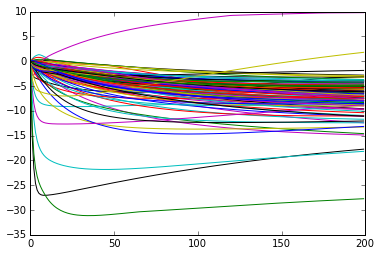

In [26]:
_=plt.plot(beh[:,slice(0,-1,200)]-beh[0,slice(0,-1,200)])

In [27]:
##loss in "final_validation_loss" = last point of "best_error_history"
print np.min(beh[:,-2])
print fvl[-2]

330.338500977
330.338500977


#### diff between first and last point of loss history, all voxels

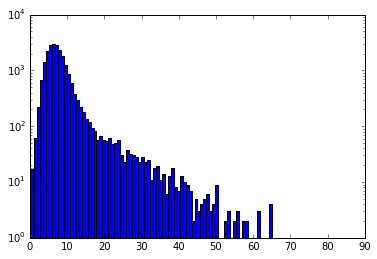

In [28]:
_=plt.hist(beh[0,1:]-np.min(beh[:,1:],axis=0),100)
plt.yscale('log')

### Step 6: model analysis and validation

#### histogram of rf models selected for each voxel

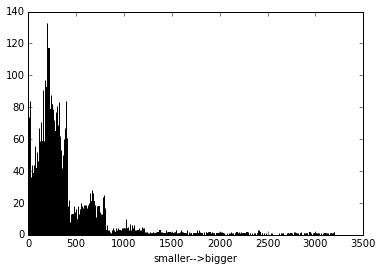

In [29]:
_=plt.hist(frf,ms.receptive_fields.G)
plt.xlabel('smaller-->bigger')

#### sum of all selected rfs. 

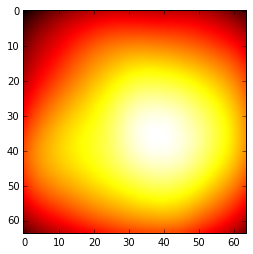

In [30]:
plt.imshow(np.sum(ms.receptive_fields.make_rf_stack(64, min_pix_per_radius=1)[frf,:,:], axis=0), cmap='hot')

#### prediction accuracy for all voxels

In [31]:
##generate predictions
# pred = prediction_menu(val_mst, ffw[np.newaxis,:,:], rf_indices = frf) ##<<too big, choked. 


##generate predictions one voxel at a time
pred = np.zeros((Tval,nvox))
for v in range(nvox):  ##<<some kind of bug in training function, last voxel getting skipped.
    pred[:,v] = np.squeeze(bigmult(validation_mst[np.newaxis,frf[v],:,:],
                                   ffw[np.newaxis,:,v, np.newaxis]))

In [32]:
validation_mst.shape

(3200, 120, 64)

In [33]:
##get correlation = prediction accuracy
val_cc = []  
for v in range(nvox): 
    cc = pearsonr(val_voxel_data[:,v],pred[:,v])
    if not np.isnan(cc[0]):
        val_cc.append(cc[0])

(-0.4, 0.9)

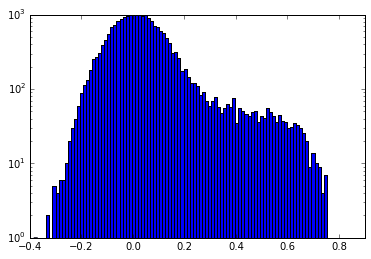

In [34]:
##histogram of prediction accuracy, all voxels
_=plt.hist(val_cc,100)
plt.yscale('log')
plt.ylim([10**0, 10**3])
plt.xlim([-.4, 0.9])

#### compare to deepnet model

In [35]:
deepnet_valcc  = h5py.File('/media/tnaselar/Data/deepnet_vim-1/feature_weighted_models/conv5_seperable.hdf5','r')['conv5_validation_cc']

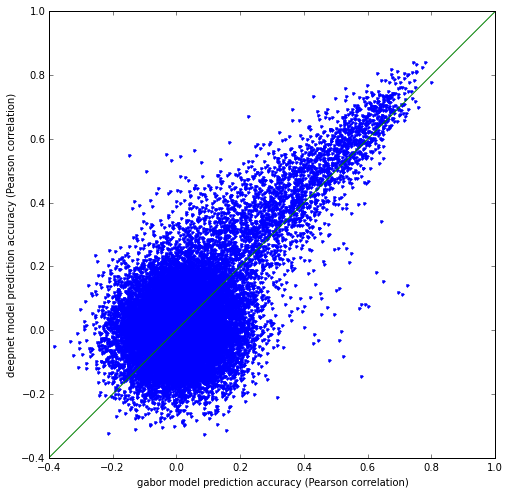

In [36]:
plt.figure(figsize=(8,8))
plt.plot(val_cc, deepnet_valcc, '.')
plt.xlim([-0.4, 1])
plt.ylim([-0.4, 1])
plt.axes().set_aspect(1)
plt.plot(np.linspace(-1, 1, num=100),np.linspace(-1, 1, num=100))

plt.xlabel('gabor model prediction accuracy (Pearson correlation)')
plt.ylabel('deepnet model prediction accuracy (Pearson correlation)')


huh. the deepnet model is so so much better.

#### area-wise rf size vs. eccentricity

In [37]:
##get position information. need to re-open file
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file,'r')

vox_position = crcns_voxel_data['voxIdxS1'][0,no_nan]  ##index into a 64 x 64 x 18 volume (matlab-style raveling)

##get the indices for visual areas
roi_indicator = crcns_voxel_data['roiS1'][0, no_nan]
roi_names = ['other', 'v1', 'v2', 'v3', 'v3A', 'v3B', 'v4', 'LO']

crcns_voxel_data.close()

In [38]:
## construct data table of rfs--indices will now be voxels
frf_sizes = ms.receptive_fields.rf_table.loc[frf,'deg_per_radius'].values
frf_eccentricities = ms.receptive_fields.rf_table.loc[frf, ['x_deg','y_deg']].apply(lambda row: np.sqrt(row['x_deg']**2+row['y_deg']**2),axis=1).values
named_voxels = [roi_names[int(v)] for v in roi_indicator]

In [39]:
model_table = pd.DataFrame(data=list(frf_sizes), columns=['roi_size'])
model_table['eccentricity'] = frf_eccentricities
model_table['area'] = named_voxels
model_table['valcc'] = val_cc

model_table

,roi_size,eccentricity,area,valcc
0,0.500000,12.740756,other,0.022503
1,0.500000,8.321783,other,0.132347
2,0.500000,11.065156,other,-0.190490
3,2.642857,11.932404,other,0.098461
4,0.500000,8.321783,other,0.101456
5,0.500000,10.123886,other,0.030335
6,0.500000,6.862318,other,0.144869
7,2.642857,8.321783,other,-0.085136
8,1.571429,4.993070,other,-0.118626
9,0.500000,10.657082,other,-0.025805


In [40]:
val_thresh = 0.25
size_means = {}
size_stds = {}
area_eccs = {}
for roi in roi_names:
    area_stats = model_table.loc[(model_table['area']==roi) & (model_table['valcc'] > val_thresh),['roi_size', 'eccentricity']]
    ecc_grp = area_stats.groupby(by='eccentricity')
    size_means[roi] = []
    size_stds[roi] = []
    area_eccs[roi] = []
    for name,grp in ecc_grp:
        area_eccs[roi].append(name)
        size_means[roi].append(grp.roi_size.mean())
        size_stds[roi].append(grp.roi_size.std())
    

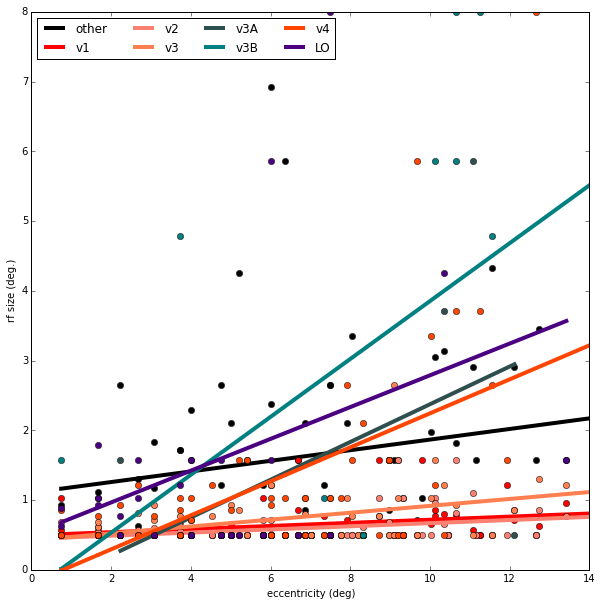

In [41]:
roi_colors = ['black', 'r', 'salmon', 'coral', 'darkslategray', 'teal','orangered', 'indigo' ]
ecc = np.sort(np.unique(model_table['eccentricity']))
line_list = []
fig = plt.figure(figsize=(10,10))
for r,roi in enumerate(roi_names):
    plt.plot(area_eccs[roi],size_means[roi], 'o', color=roi_colors[r])
    p = np.polyfit(area_eccs[roi],size_means[roi],1)
    l, = plt.plot(area_eccs[roi], np.polyval(p,area_eccs[roi]), color=roi_colors[r], label=roi, linewidth=4)
    line_list.append(l)
    
plt.legend(loc='upper left', ncol = 4)    
# plt.axis('equal')
plt.xlim([0,14])
plt.ylim([0,8])
plt.xlabel('eccentricity (deg)')
plt.ylabel('rf size (deg.)')


#### area-wise prediction accuracy

In [42]:
areawise_accuracy = []
deepnet_areawise_accuracy = []
for ii,roi in enumerate(roi_names):
    voxels_in_roi = roi_indicator == ii
    areawise_accuracy.append(np.array(val_cc)[voxels_in_roi])
    deepnet_areawise_accuracy.append(np.array(deepnet_valcc)[voxels_in_roi])
n_rois = len(roi_names)

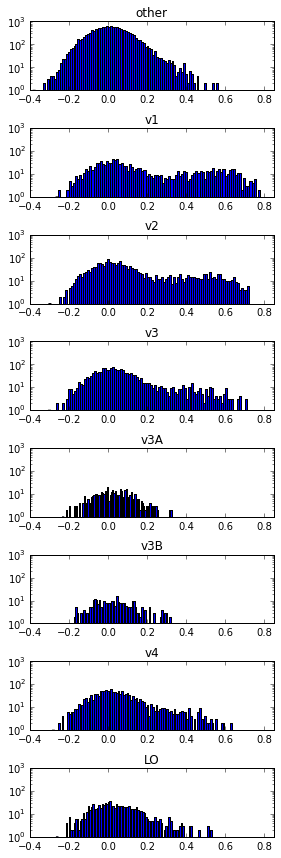

In [43]:
fig = plt.figure(figsize = (4,12))
for ii,roi in enumerate(roi_names):
    plt.subplot(n_rois,1,ii+1)
    plt.hist(areawise_accuracy[ii],100)
    plt.yscale('log')
    plt.xlim([-0.4, 0.85])
    plt.ylim([0, 10**3])
    plt.title(roi)
plt.tight_layout()  

#### area-wise comparison to deepnet

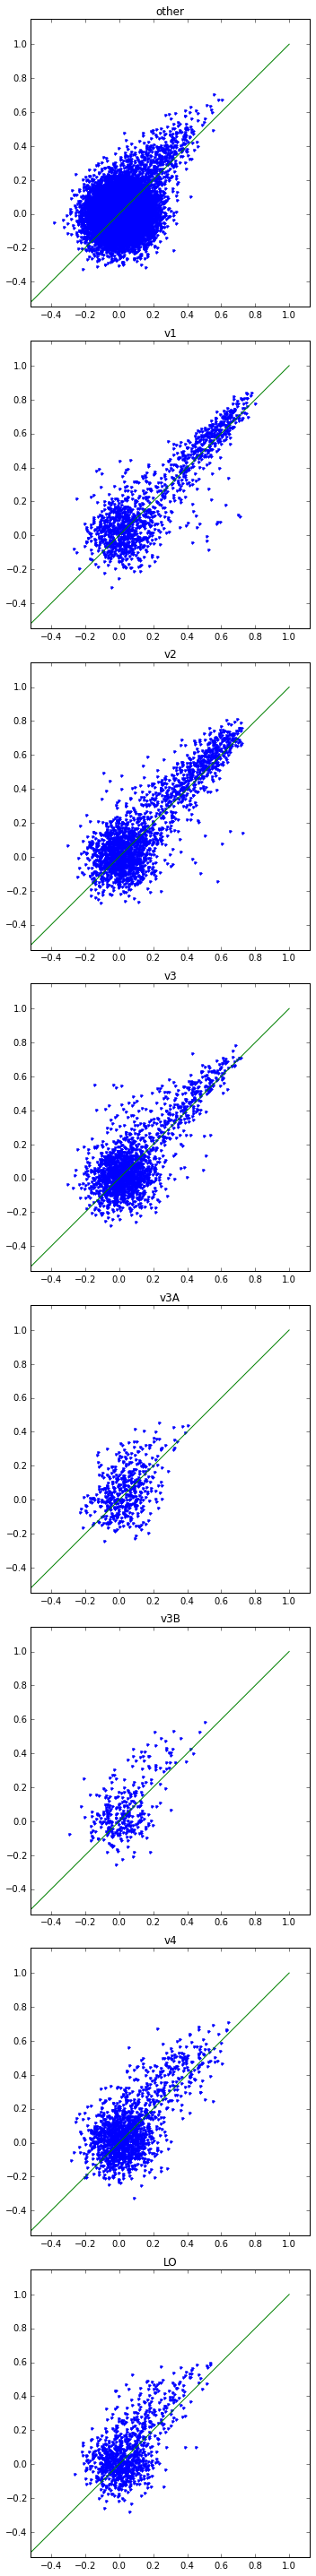

In [44]:
fig = plt.figure(figsize = (5,40))
for ii,roi in enumerate(roi_names):
    plt.subplot(n_rois,1,ii+1)
    plt.plot(areawise_accuracy[ii],deepnet_areawise_accuracy[ii], '.')
    plt.axis('equal')
    plt.plot(np.linspace(-1, 1, num=100),np.linspace(-1, 1, num=100),hold=True)
    plt.xlim([-0.4, 1])
    plt.ylim([-0.4, 1])

    plt.title(roi)
plt.tight_layout()  